<a href="https://colab.research.google.com/github/Avery1493/DS-Unit-2-Kaggle-Challenge/blob/master/module3-cross-validation/Quinn_223_of_LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
#BASELINE
train['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

# Wrangle Function

In [0]:
#Columns not need 
to_leave_out = ['amount_tsh', 'wpt_name', 'num_private',
                'subvillage','lga', 'ward','recorded_by','scheme_name',
                'extraction_type','extraction_type_group','management',
                'payment','water_quality','quantity','source_type','waterpoint_type']

#Other
fine = ['basin', 'region_code', 'district_code',
        'extraction_type_class','quality_group','quantity_group',
        'source', 'source_class', 'waterpoint_type_group']

top = ['funder','installer','scheme_management']
nans = ['longitude', 'latitude','gps_height','population',
        'construction_year', 'management_group','payment_type']
other = ['id', 'region', 'date_recorded']
boolean = ['public_meeting','permit']

In [0]:
import numpy as np

def wrangle(X):
  #make copy
  X = X.copy()
  
  #Fixing latitude outlier
  X['latitude'] = X['latitude'].replace(-2e-08, 0)
  #Making True/False Zero/One
  for col in boolean:
    X[col] = X[col].replace({True:1, False:0,'':0})

  #Replacing zeors with NaNs
  columns_with_zeros = nans
  for col in columns_with_zeros:
    X[col] = X[col].replace(0, np.nan)

  #Deleting Duplicate or Constant Columns
  X = X.drop(columns = to_leave_out)
  
  #High Cardinality Features
  high_cardinality = top
  for col in high_cardinality:
    top5 = X[col].value_counts()[:5].index
    X.loc[~X[col].isin(top5), col] = 'Other'
  
  # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'],
                                      infer_datetime_format=True)
    
  # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X = X.drop(columns='date_recorded')
    
  # Engineer feature: how many years from construction_year to date_recorded
  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()

  return X

train = wrangle(train)
test = wrangle(test)
train.shape, test.shape

((59400, 27), (14358, 26))

# MAP

In [0]:
df = train.copy()
df['district_code'] = df['district_code'].astype('category')
df['district_code'].dtype

CategoricalDtype(categories=[0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 23, 30, 33, 43, 53, 60, 62,
                  63, 67, 80],
                 ordered=False)

In [0]:
import plotly.express as px
px.scatter(df, x='longitude', y='latitude', color='district_code', opacity=.2)

In [0]:
px.scatter(df, x='longitude', y='latitude', color='region', opacity=0.1)

In [0]:
px.scatter(df, x='longitude', y='latitude', color='region_code', opacity=0.1)

# Features

In [0]:
#TARGET is status group
target = 'status_group'

#Drop target and id columns 
train_features = train.drop(columns=[target, 'id'])

#Numerical Columns
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

#Catergorical Columns
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 50].index.tolist()

#FEATURES
features = numeric_features + categorical_features

print(len(features),'Features')
print(features)

25 Features
['gps_height', 'longitude', 'latitude', 'region_code', 'district_code', 'population', 'construction_year', 'year_recorded', 'years', 'funder', 'installer', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group', 'years_MISSING']


In [0]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]

X_test = test[features]

# Random Forest

In [0]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


In [0]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=1000, max_depth=20,
                           random_state=42, n_jobs=-1)
)

#FIT on train data
pipeline.fit(X_train,y_train)

print('Train Accuracy', pipeline.score(X_train, y_train))

Train Accuracy 0.9364814814814815
CPU times: user 3min 21s, sys: 890 ms, total: 3min 22s
Wall time: 1min 43s


# Feature Importances

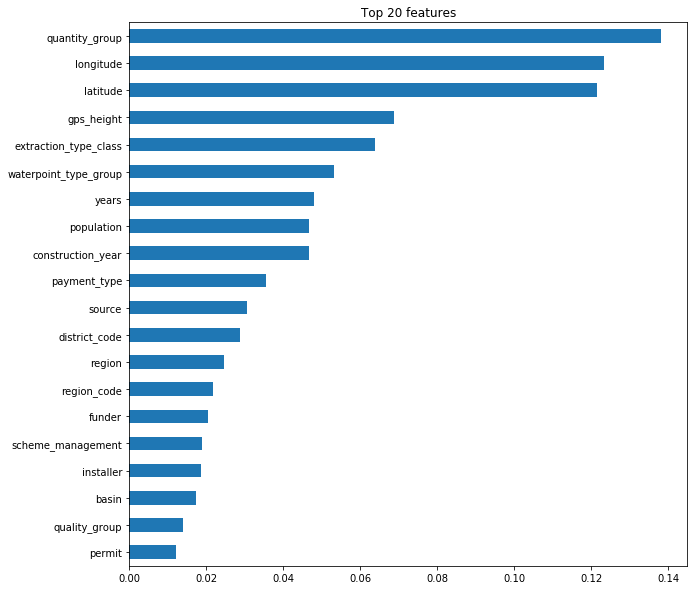

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded = encoder.transform(X_train).columns
importances = pd.Series(rf.feature_importances_, encoded)

# Plot top n feature importances
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

# Cross Validation

In [0]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=1000, max_depth=15,
                           random_state=42, n_jobs=-1)
)

k=4
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'Accuracy for {k} folds:', scores)

Accuracy for 4 folds: [0.80484848 0.79292929 0.78936027 0.79508418]
CPU times: user 30.9 s, sys: 2.29 s, total: 33.2 s
Wall time: 3min 38s


In [0]:
#AVERAGE ACCURACY SCORES
scores.mean()

0.7955555555555556

In [0]:
y_pred = pipeline.predict(X_test)
d = {'id': test['id'], 'status_group': y_pred}
sub = pd.DataFrame(d)
sub.to_csv('Quinn_submission.csv', index=False)

# Hyperparameter Optimization 

In [0]:
print('Model Hyperparameters:')
pipeline.named_steps['randomforestclassifier']

Model Hyperparameters:


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
%%time
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, max_depth=20,
                           random_state=42, n_jobs=-1)
)

param_distributions = {
    'randomforestclassifier__n_estimators': [100, 150, 200],
    'randomforestclassifier__max_depth': [10, 15, 20, 25, None],
    'simpleimputer__strategy': ['mean', 'median']
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 5,
    scoring = 'accuracy',
    n_jobs = -1,
    cv=3,
    verbose=10,
    return_train_score=True
)

search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.5min finished


CPU times: user 18.7 s, sys: 302 ms, total: 19 s
Wall time: 2min 41s


In [0]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': 20}
Cross-validation Accuracy 0.8070875420875421


In [0]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

In [0]:
pd.DataFrame(search.cv_results_)

mean_fit_time  std_fit_time  ...  mean_train_score  std_train_score
0      12.480591      0.189698  ...          0.984040         0.001918
1      10.599686      0.262077  ...          0.863123         0.006397
2      11.871965      0.161630  ...          0.944268         0.004606
3      24.447834      0.568846  ...          0.996380         0.000031
4      18.543225      0.427578  ...          0.983796         0.002169

[5 rows x 19 columns]